In [44]:
import pandas as pd
import numpy as np
from pymoo.algorithms.unsga3 import UNSGA3
from pymoo.optimize import minimize
import pickle

from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination

from combined_problem import CombinedProblem
from initial_contact_problem import InitialContactProblem
from notebooks.optimization_problems.constraints import Requirements

In [45]:
columns = ['strand_name', 'tof',
           'r_a_x', 'r_a_y', 'r_a_z',
           'v_a_x', 'v_a_y', 'v_a_z',
           'r_b_x', 'r_b_y', 'r_b_z',
           'd',
           'r_ab_sff_x', 'r_ab_sff_y', 'r_ab_sff_z']

file_path = "telesat_post_processed.h5"

row_limit = -1

store_500km = pd.HDFStore(file_path)

instances_500km_df = store_500km.select('contact_instances', 'columns = %s' % str(columns), stop = row_limit)

# Sort by pass id
instances_500km_df = instances_500km_df.sort_index(0)
instances_df = instances_500km_df

T_orbit = 5680
T_sim = T_orbit * 3

In [46]:
from notebooks.optimization_problems.design_vector import design_vector_default_scm, SystemParameters

problem = InitialContactProblem(instances_df)

sampling, crossover, mutation = design_vector_default_scm(problem.x_length, problem.x_indices)

algo_settings = {'pop_size': 100, 'n_offsprings': 25, 'n_max_gen': 5000}

settings = {}

# R-NSGA-II
from pymoo.algorithms.rnsga2 import RNSGA2
ref_points = -1 * np.ones((problem.N_passes, 2)) * T_sim
ref_points[:, 1] = -1 * (np.arange(problem.N_passes) + 1)

settings['RNSGA-II'] = {
    'label': 'rnsga2',
    'algorithm': RNSGA2(
        pop_size=algo_settings['pop_size'],
        n_offsprings=algo_settings['n_offsprings'],
        sampling=sampling,
        crossover=crossover,
        mutation=mutation,
        eliminate_duplicates=True,
        ref_points=ref_points,
        epsilon=0.001,
        normalization='no',
        extreme_points_as_reference_points=False,
        #weights=np.array([0.5, 0.5, 0.5])
    ),
    'termination': None
}

# U-NSGA-III
from pymoo.algorithms.nsga3 import NSGA3
from pymoo.factory import get_reference_directions, get_visualization, get_termination

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=299)
print("# dirs: %d" % len(ref_dirs))

#get_visualization("scatter").add(ref_dirs).show()
settings['UNSGA-III'] = {
    'label': 'unsga3',
    'algorithm': UNSGA3(
        pop_size=int(np.ceil(len(ref_dirs) / 100) * 100),
        #n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4),
        n_offsprings=10,
        sampling=sampling,#InitialSampling(),
        crossover=crossover,
        mutation=mutation,
        ref_dirs=ref_dirs,
        eliminate_duplicates=False,
    ),
    # 'termination': MultiObjectiveSpaceToleranceTermination(tol=0.00001,
    #                                                   n_last=30,
    #                                                   nth_gen=5,
    #                                                   n_max_gen=algo_settings['n_max_gen'],
    #                                                   n_max_evals=None)
    'termination': get_termination("time", "01:00:00")
}

setting = settings['RNSGA-II']
print('pop_size: %d' % setting['algorithm'].pop_size)
print('n_offspring: %d' % setting['algorithm'].n_offsprings)

# dirs: 300
pop_size: 100
n_offspring: 25


In [47]:
termination = setting['termination']
algorithm = setting['algorithm']

n_gen_inc = 1000

In [48]:
from os import path

file_name = 'Initial_Telesat_%s_%d_%d.pkl' % (setting['label'], algorithm.pop_size, algorithm.n_offsprings)

if path.exists(file_name):
    problem, setting, res = pickle.load(open(file_name, 'rb'))
    algorithm = res.algorithm
    algorithm.has_terminated = False
    n_gen = res.algorithm.n_gen
else:
    n_gen = 0

In [49]:
n_gen = n_gen + n_gen_inc
print(n_gen)

res = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               #termination=termination,
               seed=1,
               #save_history=True,
               verbose=True,
               copy_algorithm=False,
               )

print('Processes:', res.exec_time)
print("Best solution found: %s" % res.X)

pickle.dump((problem, setting, res), open(file_name, 'wb'))

2000
 1001 |   25100 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1002 |   25125 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1003 |   25150 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1004 |   25175 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1005 |   25200 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1006 |   25225 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1007 |   25250 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1008 |   25275 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1009 |   25300 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1010 |   25325 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1011 |   25350 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
 1012 |   25375 |  0.00000E+00 |  0.00000E+00 |  

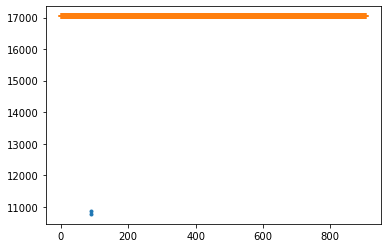

In [50]:
import matplotlib.pyplot as plt

x_pass = res.X[:, problem.x_indices['pass']].astype('bool')

f_contact = -1*res.F[:,0]
f_pass = -1*res.F[:, 1]

fig, ax = plt.subplots()
ax.scatter(f_pass, f_contact, marker='.')
ax.scatter(-1*ref_points[:,1], -1*ref_points[:,0], marker='+')